# see spped dif between storingf zlevel br node and by face

In [6]:
from numba import njit ,types as nbt, typeof, from_dtype, prange
import numpy as np
from timeit import timeit
from oceantracker.util import ncdf_util

fn = r'G:\Hindcasts_large\MalbroughSounds_10year_benPhD\2008\schism_marl20080101_00z_3D.nc'
nc = ncdf_util.NetCDFhandler(fn) 

d = nc.read_variables(['zcor','SCHISM_hgrid_face_nodes','node_bottom_index'])

zlevel= d['zcor']
tri= d['SCHISM_hgrid_face_nodes'][:,:3] -1
node_bottom_index = d['node_bottom_index'] -1





# built mid face values from nodal values

In [7]:

@njit
def get_face_vals(data, tri,node_bottom_index):
    s= list(data.shape)

    out = np.full((s[0],tri.shape[0],3,s[2]),np.nan, dtype=np.float32 )
    for nt in range(data.shape[0]): # step over time dim
        for ntri in range(tri.shape[0]):
            for m in range(3): # loopover faces
            # face value is mean of nodal vales opposite the face number
                node1 = tri[ntri, (m+1) %3]
                node2 = tri[ntri, (m+2) %3]
                
                for nz in range(data.shape[2]):
                    # make sure node is not below bottom node in LSC grid
                    nz1 = max(node_bottom_index[node1],nz)
                    nz2 = max(node_bottom_index[node1],nz)

                    out[nt,ntri,m, nz] = 0.5*(data[nt, node1,nz1] +data[nt,node2,nz2] )
   
            pass 
    return out


nt=10
ntri= 400
nz = -5
print(zlevel.shape,zlevel[nt,tri[ntri,:],nz])
z_level_face= get_face_vals(zlevel, tri, node_bottom_index)

print(z_level_face.shape,z_level_face[nt,ntri,:,nz])

(48, 149233, 38) [0.3840408  0.2836658  0.43160763]
(48, 274359, 3, 38) [0.35763672 0.40782422 0.3338533 ]


In [8]:
@njit
def access_by_node(data, triangles, n_cell, out, active, work):
    s =0.
    for nt in range(data.shape[0]): # test over all time steps
        for n in active: # step over particles
            nodes = triangles[n_cell[n], :]  # nodesin triangles
            for m in range(3): # loopover faces 
                node = nodes[m]
                for w in range(work):
                    out[n] = data[nt, node, -1]  # only do top depth
                    s += out[n]
    return s # check sum
            
@njit(parallel=False)
def access_by_tri(data_by_tri,n_cell, out, active, work):
    s =0.
    for nt in prange(data_by_tri.shape[0]): # test over all time steps 
        data= data_by_tri[nt, :, : , :] 
        for n in active: # step over particles
            nc = n_cell[n]  
            
            for m in range(3): # loopover faces 
                for w in range(work):   
                    out[n] = data[nc, m, -1] # only do top depth
                    s += out[n]
    return s # check sum       
                

In [11]:
repeats = 10

num_particles = np.asarray([10**3,5*10**3, 10**4, 2*10**4,5*10**4, 10**5, 5*10**5,10**6, 2*10**6 , 5*10**6],dtype=np.int32)
work = np.asarray([1, 5, 10], dtype=np.int32)
#num_particles = np.asarray([],dtype=np.int32)
print('Setup',num_particles,num_particles.size)
N = num_particles.size
M = work.size
t1= np.zeros((N,M),dtype=np.float64)
t2= np.zeros((N,M),dtype=np.float64)

frac =.5

for m, w in enumerate(work):
    for n ,n_part in enumerate(num_particles):    
        print('doing',w, n_part)
        out = np.zeros((n_part,), dtype=np.float64)

        n_cell = np.random.randint(0, high = tri.shape[0], size=n_part)
        active = np.sort(np.random.choice(np.arange(n_part), size=int(n_part*frac), replace=False))

        # compile and  print results
        v1= access_by_node(zlevel[:10,...], tri,  n_cell, out, active, w)
        v2 = access_by_tri(z_level_face[:10,...], n_cell, out, active, w)
        
        t1[n,m]=  timeit(lambda  : access_by_node(zlevel, tri, n_cell, out, active, w),  number =repeats) 
        t2[n,m]=  timeit(lambda  : access_by_tri(z_level_face, n_cell, out, active, w),  number =repeats) 


   

Setup [   1000    5000   10000   20000   50000  100000  500000 1000000 2000000
 5000000] 10
doing 1 1000
doing 1 5000
doing 1 10000
doing 1 20000
doing 1 50000
doing 1 100000
doing 1 500000
doing 1 1000000
doing 1 2000000
doing 1 5000000
doing 5 1000
doing 5 5000
doing 5 10000
doing 5 20000
doing 5 50000
doing 5 100000
doing 5 500000
doing 5 1000000
doing 5 2000000
doing 5 5000000
doing 10 1000
doing 10 5000
doing 10 10000
doing 10 20000
doing 10 50000
doing 10 100000
doing 10 500000
doing 10 1000000
doing 10 2000000
doing 10 5000000


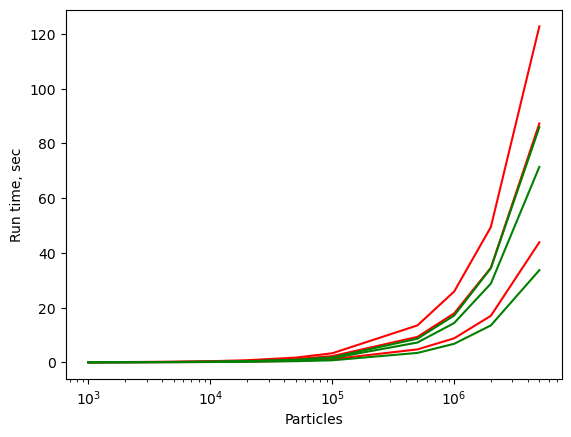

Text(0, 0.5, 'Relative speed')

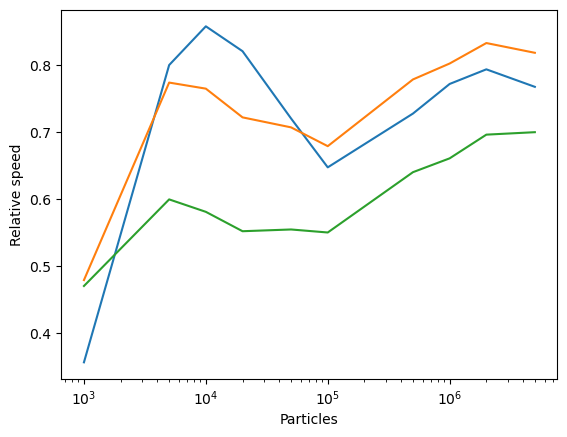

In [13]:
# plot    
from matplotlib import pyplot as plt
fig,ax = plt.subplots()   
ax.plot(num_particles,t1,label='Acess by node',c='r')
ax.plot(num_particles,t2,label='Acess by cell',c='g')
ax.set_xscale('log')
ax.set_xlabel('Particles')
ax.set_ylabel('Run time, sec')

plt.show()
fig,ax = plt.subplots()   
ax.plot(num_particles,t2/t1)
ax.set_xscale('log')
ax.set_xlabel('Particles')
ax.set_ylabel('Relative speed')

#ax.legend(prop={'size': 8})